# <span style="color: blue;">Part 4.1: Curation of model - NGAM and GAM</span>

- The pathways for sugar metabolism?
- The pathways for fermentation product formation?
- The GAM and NGAM
- Transport reactions
    - Here I can use the MEMOTE results
- Whatever else is necessary


In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import reframed
from reframed import pFBA, Environment
import matplotlib.pyplot as plt
import warnings

## <span style="color: blue;">Determining NGAM and GAM</span>

To determine NGAM and GAM:
- NGAM: 
    - Determine uptake of sugar at 0 growth rate (from experimental data).
    - Maximize ATP production
- GAM: 
    - Fix growth rate and uptake of sugar.
    - Determine maximum ATP production (divided by growth rate)
    - Take an baverage of this value. 

In [2]:
model = reframed.load_cbmodel('model_c_H10_part3_3_1.xml')

In [3]:
media = pd.read_csv('carveMe input/carveMe_medium.tsv',sep='\t')
media_cellb = media[media.medium=='H10_defined_medium_cellobiose']
media_cellb_list = list(media_cellb['compound'])

# Create an environment object
env_cellb = Environment.from_compounds(media_cellb_list)

with warnings.catch_warnings(): # The code will create warnings because some of the compounds in the media are not in the model
    warnings.simplefilter('ignore')
    
    # Apply envrironment to model
    env_cellb.apply(model, inplace=True, exclusive=True)

In [4]:
%store -r mu
%store -r q_cellb

In [5]:
pd.DataFrame({"growth rate":mu, "cellobiose uptake":q_cellb})

,growth rate,cellobiose uptake
0,0.016,0.63
1,0.033,0.89
2,0.053,1.34
3,0.062,1.41
4,0.085,1.55
5,0.120,1.86
6,0.138,1.98


In [6]:
#Setting GAM values in biomass function
model.reactions.Growth.stoichiometry['M_atp_c']=0
model.reactions.Growth.stoichiometry['M_adp_c']=0
model.reactions.Growth.stoichiometry['M_h_c']=0
model.reactions.Growth.stoichiometry['M_pi_c']=0

#### <span style="color: blue;">Linear regression</span>

Finding max ATP production when fixing growth rate and cellobiose uptake.

In [7]:
ATP=[]

objective = dict.fromkeys(model.reactions,0)
objective['R_ATPM'] = 1

constraints = {'R_EX_glc__D_e':0,
       'R_EX_so4_e':(-2.45,1000),
       'R_EX_pi_e':(-7.46,1000),
       'R_EX_nh4_e':(-4.9,1000)}

for i, q_cellb_i in enumerate(q_cellb):
    constraints['R_EX_cellb_e']=-q_cellb_i
    constraints['Growth']=mu[i]
    sol = pFBA(model,constraints=constraints,objective=objective)
    ATP.append(sol.values['R_ATPM'])

In [8]:
ATP

[4.45349744,
 5.910338469999999,
 8.595173013666596,
 8.760705537999925,
 8.898547914999927,
 9.672558871999984,
 9.805842702799977]

In [9]:
x = mu[:-1].reshape((-1,1))
y = ATP[:-1]

In [10]:
lin_model = LinearRegression().fit(x,y)

In [11]:
r_sq = lin_model.score(x, y)

In [12]:
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.7723136721951847


In [13]:
y_pred = lin_model.predict(x)

*Plotting the data*: Does not really follow a linear trend. 

Text(0, 0.5, 'ATP [mmol/g CDW h]')

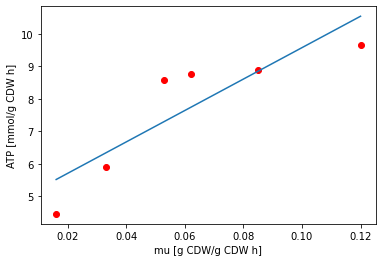

In [14]:
plt.plot(x,y,'ro')
plt.plot(x,y_pred)
plt.xlabel('mu [g CDW/g CDW h]')
plt.ylabel('ATP [mmol/g CDW h]')

<span style="color: blue;">**Determining NGAM**</span>

In [15]:
NGAM=lin_model.intercept_
print(f"NGAM: {lin_model.intercept_}")

NGAM: 4.740175464355865


<span style="color: blue;">**Determining GAM**</span>

This seems very high based on the results from Part 1.1.1.

In [16]:
GAM=lin_model.coef_[0]
print(f"GAM: {lin_model.coef_[0]}")

GAM: 48.37335626702233


<span style="color: blue;">**Testing new values for NGAM and GAM**</span>

In [17]:
#Setting GAM values in biomass function
model.reactions.Growth.stoichiometry['M_atp_c']=-GAM
model.reactions.Growth.stoichiometry['M_adp_c']=GAM
model.reactions.Growth.stoichiometry['M_h_c']=GAM
model.reactions.Growth.stoichiometry['M_pi_c']=GAM

In [18]:
#Setting NGAM values in the ATPM function
model.reactions.R_ATPM.ub=1000
model.reactions.R_ATPM.lb=NGAM

In [19]:
## pFBA prediction of growth rate and product production
mu_predict = []

constraints = {'R_EX_glc__D_e':0,
       'R_EX_so4_e':(-2.45,1000),
       'R_EX_pi_e':(-7.46,1000),
       'R_EX_nh4_e':(-4.9,1000)}

for i,q_cellb_i in enumerate(q_cellb):
    constraints['R_EX_cellb_e']=(-q_cellb_i,0)
    sol = pFBA(model,constraints=constraints)
    print(sol.status)
    mu_predict.append(sol.values['Growth']) 
    

Status.OPTIMAL
Status.OPTIMAL
Status.OPTIMAL
Status.OPTIMAL
Status.OPTIMAL
Status.OPTIMAL
Status.OPTIMAL


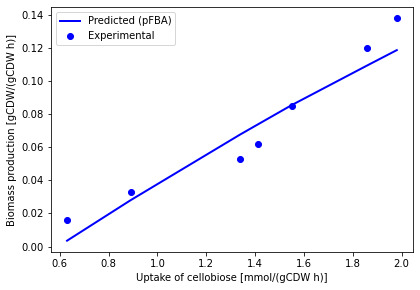

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(6.5, 4.5)
ax.plot(q_cellb,mu_predict, linewidth=2,label="Predicted (pFBA)",color='blue')
ax.plot(q_cellb,mu,'bo',label="Experimental")
plt.ylabel(f'Biomass production [gCDW/(gCDW h)]')
plt.xlabel("Uptake of cellobiose [mmol/(gCDW h)]")

plt.legend(loc='upper left')
plt.savefig("image.png", dpi=300)
plt.show()



plt.savefig("image.png", dpi=300)

### <span style="color: blue;">Saving final model</span>

In [21]:
model.id = "model_c_H10_part4_1"

In [22]:
model.update()

In [23]:
reframed.save_cbmodel(model,filename="model_c_H10_part4_1.xml")